# Predicting House Prices on Kaggle
:label:`sec_kaggle_house`

Now that we have introduced some basic tools
for building and training deep networks
and regularizing them with techniques including
weight decay and dropout,
we are ready to put all this knowledge into practice
by participating in a Kaggle competition.
The house price prediction competition
is a great place to start.
The data are fairly generic and do not exhibit exotic structure
that might require specialized models (as audio or video might).
This dataset, collected by Bart de Cock in 2011 :cite:`De-Cock.2011`,
covers house prices in Ames, IA from the period of 2006--2010.
It is considerably larger than the famous [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) of Harrison and Rubinfeld (1978),
boasting both more examples and more features.


In this section, we will walk you through details of
data preprocessing, model design, and hyperparameter selection.
We hope that through a hands-on approach,
you will gain some intuitions that will guide you
in your career as a data scientist.


## Downloading and Caching Datasets

Throughout the book, we will train and test models
on various downloaded datasets.
Here, we (**implement several utility functions
to facilitate data downloading**).
First, we maintain a dictionary `DATA_HUB`
that maps a string (the *name* of the dataset)
to a tuple containing both the URL to locate the dataset
and the SHA-1 key that verifies the integrity of the file.
All such datasets are hosted at the site
whose address is `DATA_URL`.


In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

The following `download` function downloads a dataset,
caches it in a local directory (`../data` by default),
and returns the name of the downloaded file.
If a file corresponding to this dataset
already exists in the cache directory
and its SHA-1 matches the one stored in `DATA_HUB`,
our code will use the cached file to avoid
clogging up your internet with redundant downloads.


In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

We also implement two additional utility functions:
one is to download and extract a zip or tar file
and the other to download all the datasets used in this book from `DATA_HUB` into the cache directory.


In [3]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
that hosts machine learning competitions.
Each competition centers on a dataset and many
are sponsored by stakeholders who offer prizes
to the winning solutions.
The platform helps users to interact
via forums and shared code,
fostering both collaboration and competition.
While leaderboard chasing often spirals out of control,
with researchers focusing myopically on preprocessing steps
rather than asking fundamental questions,
there is also tremendous value in the objectivity of a platform
that facilitates direct quantitative comparisons
among competing approaches as well as code sharing
so that everyone can learn what did and did not work.
If you want to participate in a Kaggle competition,
you will first need to register for an account
(see :numref:`fig_kaggle`).

![The Kaggle website.](../img/kaggle.png)
:width:`400px`
:label:`fig_kaggle`

On the house price prediction competition page, as illustrated
in :numref:`fig_house_pricing`,
you can find the dataset (under the "Data" tab),
submit predictions, and see your ranking,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![The house price prediction competition page.](../img/house-pricing.png)
:width:`400px`
:label:`fig_house_pricing`

## Accessing and Reading the Dataset

Note that the competition data is separated
into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features consist of various data types.
For example, the year of construction
is represented by an integer,
the roof type by discrete categorical assignments,
and other features by floating point numbers.
And here is where reality complicates things:
for some examples, some data are altogether missing
with the missing value marked simply as "na".
The price of each house is included
for the training set only
(it is a competition after all).
We will want to partition the training set
to create a validation set,
but we only get to evaluate our models on the official test set
after uploading predictions to Kaggle.
The "Data" tab on the competition tab
in :numref:`fig_house_pricing`
has links to download the data.


To get started, we will [**read in and process the data
using `pandas`**], which we have introduced in :numref:`sec_pandas`.
So, you will want to make sure that you have `pandas` installed
before proceeding further.
Fortunately, if you are reading in Jupyter,
we can install pandas without even leaving the notebook.


In [4]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


For convenience, we can download and cache
the Kaggle housing dataset
using the script we defined above.


In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

We use `pandas` to load the two csv files containing training and test data respectively.


In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

The training dataset includes 1460 examples,
80 features, and 1 label, while the test data
contains 1459 examples and 80 features.


In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let us [**take a look at the first four and last two features
as well as the label (SalePrice)**] from the first four examples.


In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, (**the first feature is the ID.**)
This helps the model identify each training example.
While this is convenient, it does not carry
any information for prediction purposes.
Hence, (**we remove it from the dataset**)
before feeding the data into the model.


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Data Preprocessing

As stated above, we have a wide variety of data types.
We will need to preprocess the data before we can start modeling.
Let us start with the numerical features.
First, we apply a heuristic,
[**replacing all missing values
by the corresponding feature's mean.**]
Then, to put all features on a common scale,
we (***standardize* the data by
rescaling features to zero mean and unit variance**):

$$x \leftarrow \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ denote mean and standard deviation, respectively.
To verify that this indeed transforms
our feature (variable) such that it has zero mean and unit variance,
note that $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
and that $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitively, we standardize the data
for two reasons.
First, it proves convenient for optimization.
Second, because we do not know *a priori*
which features will be relevant,
we do not want to penalize coefficients
assigned to one feature more than on any other.


In [10]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

[**Next we deal with discrete values.**]
This includes features such as "MSZoning".
(**We replace them by a one-hot encoding**)
in the same way that we previously transformed
multiclass labels into vectors (see :numref:`subsec_classification-problem`).
For instance, "MSZoning" assumes the values "RL" and "RM".
Dropping the "MSZoning" feature,
two new indicator features
"MSZoning_RL" and "MSZoning_RM" are created with values being either 0 or 1.
According to one-hot encoding,
if the original value of "MSZoning" is "RL",
then "MSZoning_RL" is 1 and "MSZoning_RM" is 0.
The `pandas` package does this automatically for us.


In [11]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

You can see that this conversion increases
the number of features from 79 to 331.
Finally, via the `values` attribute,
we can [**extract the NumPy format from the `pandas` format
and convert it into the tensor**]
representation for training.


In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)

## [**Training**]

To get started we train a linear model with squared loss.
Not surprisingly, our linear model will not lead
to a competition-winning submission
but it provides a sanity check to see whether
there is meaningful information in the data.
If we cannot do better than random guessing here,
then there might be a good chance
that we have a data processing bug.
And if things work, the linear model will serve as a baseline
giving us some intuition about how close the simple model
gets to the best reported models, giving us a sense
of how much gain we should expect from fancier models.


In [13]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1024), nn.Tanh(),
                        nn.Linear(1024, 512), nn.Tanh(), nn.Linear(512, 256), nn.Tanh(),
                        nn.Dropout(0.5), nn.Linear(256, 1))
    return net

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus [**we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**]
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by USD 100,000
when estimating the price of a house in Rural Ohio,
where the value of a typical house is 125,000 USD,
then we are probably doing a horrible job.
On the other hand, if we err by this amount
in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(there, the median house price exceeds 4 million USD).

(**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**)
In fact, this is also the official error measure
used by the competition to evaluate the quality of submissions.
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [15]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

Unlike in previous sections, [**our training functions
will rely on the Adam optimizer
(we will describe it in greater detail later)**].
The main appeal of this optimizer is that,
despite doing no better (and sometimes worse)
given unlimited resources for hyperparameter optimization,
people tend to find that it is significantly less sensitive
to the initial learning rate.


In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$-Fold Cross-Validation

You might recall that we introduced [**$K$-fold cross-validation**]
in the section where we discussed how to deal
with model selection (:numref:`sec_model_selection`).
We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\mathrm{th}$ fold of the data
in a $K$-fold cross-validation procedure.
It proceeds by slicing out the $i^\mathrm{th}$ segment
as validation data and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit it here owing to the simplicity of our problem.


In [16]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

[**The training and verification error averages are returned**]
when we train $K$ times in the $K$-fold cross-validation.


In [17]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## [**Model Selection**]

In this example, we pick an untuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take time,
depending on how many variables one optimizes over.
With a large enough dataset,
and the normal sorts of hyperparameters,
$K$-fold cross-validation tends to be
reasonably resilient against multiple testing.
However, if we try an unreasonably large number of options
we might just get lucky and find that our validation
performance is no longer representative of the true error.


fold 1, train log rmse 0.413666, valid log rmse 0.398178
fold 2, train log rmse 0.407319, valid log rmse 0.440124
fold 3, train log rmse 0.403072, valid log rmse 0.421949


KeyboardInterrupt: 

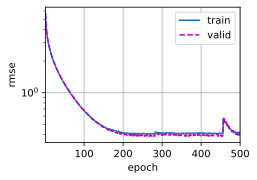

In [21]:
k, num_epochs, lr, weight_decay, batch_size = 5, 500, 1.5, 0.05, 512
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

Notice that sometimes the number of training errors
for a set of hyperparameters can be very low,
even as the number of errors on $K$-fold cross-validation
is considerably higher.
This indicates that we are overfitting.
Throughout training you will want to monitor both numbers.
Less overfitting might indicate that our data can support a more powerful model.
Massive overfitting might suggest that we can gain
by incorporating regularization techniques.

##  [**Submitting Predictions on Kaggle**]

Now that we know what a good choice of hyperparameters should be,
we might as well use all the data to train on it
(rather than just $1-1/K$ of the data
that are used in the cross-validation slices).
The model that we obtain in this way
can then be applied to the test set.
Saving the predictions in a csv file
will simplify uploading the results to Kaggle.


In [27]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

One nice sanity check is to see
whether the predictions on the test set
resemble those of the $K$-fold cross-validation process.
If they do, it is time to upload them to Kaggle.
The following code will generate a file called `submission.csv`.


train log rmse 0.146277


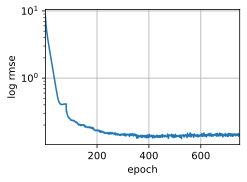

In [79]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

Next, as demonstrated in :numref:`fig_kaggle_submit2`,
we can submit our predictions on Kaggle
and see how they compare with the actual house prices (labels)
on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the house price prediction competition page.
* Click the “Submit Predictions” or “Late Submission” button (as of this writing, the button is located on the right).
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![Submitting data to Kaggle](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## Summary

* Real data often contain a mix of different data types and need to be preprocessed.
* Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
* Transforming categorical features into indicator features allows us to treat them like one-hot vectors.
* We can use $K$-fold cross-validation to select the model and adjust the hyperparameters.
* Logarithms are useful for relative errors.


## Exercises

1. Submit your predictions for this section to Kaggle. How good are your predictions?
1. Can you improve your model by minimizing the logarithm of prices directly? What happens if you try to predict the logarithm of the price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint: can you construct a situation where the values are not missing at random?
1. Improve the score on Kaggle by tuning the hyperparameters through $K$-fold cross-validation.
1. Improve the score by improving the model (e.g., layers, weight decay, and dropout).
1. What happens if we do not standardize the continuous numerical features like what we have done in this section?


[Discussions](https://discuss.d2l.ai/t/107)
